In [1]:
from bacp import BaCPTrainer, BaCPTrainingArguments
from trainer import Trainer, TrainingArguments
from utils import print_statistics, get_device, get_num_workers, print_dynamic_lambdas_statistics
from constants import *

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = 'resnet50'
MODEL_TASK = 'cifar10'
FINETUNED_WEIGHTS = './research/resnet50/cifar10/resnet50_cifar10_baseline.pt'
TRAIN = False
DEVICE = get_device()
NUM_WORKERS = get_num_workers()
print("Using device:", DEVICE)
print("Using", NUM_WORKERS, "workers")

Using device: cuda
Using 288 workers


## Baseline Check

In [13]:
training_args = TrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.01),
    scheduler_type='linear_with_warmup',
    epochs=100,
    learning_type="baseline",
    patience=50,
    db=False,
)
trainer = Trainer(training_args=training_args)
metrics = trainer.evaluate()
print_statistics(metrics, trainer)

[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.01)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Linear scheduler initialized with warmup steps: 830 and total steps: 8300
[TRAINER] Pruning not initialized
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.0



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.02%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        baseline
  Batch Size:           512
  Learning Rate:        0.01
  Optimizer:            sgd
  Epochs:               100

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24



## BaCP

In [12]:
lambdas = [1]*4
print(lambdas)
lambdas[2] = 0
print(lambdas)



[1, 1, 1, 1]
[1, 1, 0, 1]


[TRAINER] Image size: 32
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded successfully
[TRAINER] Initialized BaCP models
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.1)
[TRAINER] No scheduler initialized
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.95
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_ablation_b2.pt
[LOGGER] Log file created at location: ./log_records/resnet50/cifar10/ablation_b2/magnitude_pruning/0.95/run_2.log


Training Epoch [1/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.464.



Epoch [1/5]: Avg Total Loss: 9.5316 | Avg PrC Loss: 4.7411 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.7905 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 9.2994 | Avg PrC Loss: 4.6868 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.6125 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [2/10]: Avg Total Loss: 8.9576 | Avg PrC Loss: 4.6307 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.3270 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [3/10]: Avg Total Loss: 8.6517 | Avg PrC Loss: 4.5992 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 4.0525 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [4/10]: Avg Total Loss: 8.5317 | Avg PrC Loss: 4.5743 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.9574 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [5/10]: Avg Total Loss: 8.4666 | Avg PrC Loss: 4.5594 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.9072 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [6/10]: Avg Total Loss: 8.4374 | Avg PrC Loss: 4.5523 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.8851 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [7/10]: Avg Total Loss: 8.4124 | Avg PrC Loss: 4.5470 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.8653 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [8/10]: Avg Total Loss: 8.3964 | Avg PrC Loss: 4.5433 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.8532 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [9/10]: Avg Total Loss: 8.3844 | Avg PrC Loss: 4.5397 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.8447 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Retraining Epoch [10/10]: Avg Total Loss: 8.3771 | Avg PrC Loss: 4.5380 | Avg SnC Loss: 0.0000 | Avg FiC Loss: 3.8392 | Avg CE Loss: 0.0000 | Model Sparsity: 0.4636



Training Epoch [2/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.745.



Epoch [2/5]: Avg Total Loss: 11.8733 | Avg PrC Loss: 4.5774 | Avg SnC Loss: 3.4399 | Avg FiC Loss: 3.8560 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 11.8633 | Avg PrC Loss: 4.5779 | Avg SnC Loss: 3.4352 | Avg FiC Loss: 3.8502 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [2/10]: Avg Total Loss: 11.8346 | Avg PrC Loss: 4.5750 | Avg SnC Loss: 3.4225 | Avg FiC Loss: 3.8371 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [3/10]: Avg Total Loss: 11.8312 | Avg PrC Loss: 4.5738 | Avg SnC Loss: 3.4192 | Avg FiC Loss: 3.8382 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [4/10]: Avg Total Loss: 11.8124 | Avg PrC Loss: 4.5718 | Avg SnC Loss: 3.4102 | Avg FiC Loss: 3.8305 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [5/10]: Avg Total Loss: 11.8071 | Avg PrC Loss: 4.5710 | Avg SnC Loss: 3.4079 | Avg FiC Loss: 3.8282 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [6/10]: Avg Total Loss: 11.8037 | Avg PrC Loss: 4.5695 | Avg SnC Loss: 3.4067 | Avg FiC Loss: 3.8275 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [7/10]: Avg Total Loss: 11.7959 | Avg PrC Loss: 4.5702 | Avg SnC Loss: 3.4024 | Avg FiC Loss: 3.8233 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [8/10]: Avg Total Loss: 11.7908 | Avg PrC Loss: 4.5690 | Avg SnC Loss: 3.4010 | Avg FiC Loss: 3.8208 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448



Retraining Epoch [9/10]: Avg Total Loss: 11.7916 | Avg PrC Loss: 4.5686 | Avg SnC Loss: 3.4000 | Avg FiC Loss: 3.8230 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 11.7933 | Avg PrC Loss: 4.5698 | Avg SnC Loss: 3.4011 | Avg FiC Loss: 3.8225 | Avg CE Loss: 0.0000 | Model Sparsity: 0.7448

[BaCP] weights saved!


Training Epoch [3/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.889.



Epoch [3/5]: Avg Total Loss: 15.1988 | Avg PrC Loss: 4.6048 | Avg SnC Loss: 6.7561 | Avg FiC Loss: 3.8379 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 15.2055 | Avg PrC Loss: 4.6040 | Avg SnC Loss: 6.7610 | Avg FiC Loss: 3.8406 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 15.1617 | Avg PrC Loss: 4.6024 | Avg SnC Loss: 6.7324 | Avg FiC Loss: 3.8270 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892



Retraining Epoch [3/10]: Avg Total Loss: 15.1517 | Avg PrC Loss: 4.6017 | Avg SnC Loss: 6.7235 | Avg FiC Loss: 3.8265 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892



Retraining Epoch [4/10]: Avg Total Loss: 15.1386 | Avg PrC Loss: 4.6002 | Avg SnC Loss: 6.7143 | Avg FiC Loss: 3.8241 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892



Retraining Epoch [5/10]: Avg Total Loss: 15.1231 | Avg PrC Loss: 4.5998 | Avg SnC Loss: 6.7050 | Avg FiC Loss: 3.8183 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892



Retraining Epoch [6/10]: Avg Total Loss: 15.1076 | Avg PrC Loss: 4.5984 | Avg SnC Loss: 6.6942 | Avg FiC Loss: 3.8150 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892



Retraining Epoch [7/10]: Avg Total Loss: 15.0935 | Avg PrC Loss: 4.5973 | Avg SnC Loss: 6.6857 | Avg FiC Loss: 3.8105 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892



Retraining Epoch [8/10]: Avg Total Loss: 15.1102 | Avg PrC Loss: 4.5990 | Avg SnC Loss: 6.6969 | Avg FiC Loss: 3.8143 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 15.1014 | Avg PrC Loss: 4.5977 | Avg SnC Loss: 6.6902 | Avg FiC Loss: 3.8135 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 15.1006 | Avg PrC Loss: 4.5977 | Avg SnC Loss: 6.6890 | Avg FiC Loss: 3.8139 | Avg CE Loss: 0.0000 | Model Sparsity: 0.8892

[BaCP] weights saved!


Training Epoch [4/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.942.



Epoch [4/5]: Avg Total Loss: 18.4536 | Avg PrC Loss: 4.6260 | Avg SnC Loss: 9.9955 | Avg FiC Loss: 3.8321 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 18.4204 | Avg PrC Loss: 4.6260 | Avg SnC Loss: 9.9710 | Avg FiC Loss: 3.8235 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [2/10]: Avg Total Loss: 18.4203 | Avg PrC Loss: 4.6254 | Avg SnC Loss: 9.9690 | Avg FiC Loss: 3.8259 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [3/10]: Avg Total Loss: 18.4030 | Avg PrC Loss: 4.6234 | Avg SnC Loss: 9.9574 | Avg FiC Loss: 3.8221 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [4/10]: Avg Total Loss: 18.3896 | Avg PrC Loss: 4.6242 | Avg SnC Loss: 9.9481 | Avg FiC Loss: 3.8173 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [5/10]: Avg Total Loss: 18.3874 | Avg PrC Loss: 4.6244 | Avg SnC Loss: 9.9440 | Avg FiC Loss: 3.8190 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [6/10]: Avg Total Loss: 18.3787 | Avg PrC Loss: 4.6235 | Avg SnC Loss: 9.9383 | Avg FiC Loss: 3.8169 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [7/10]: Avg Total Loss: 18.3693 | Avg PrC Loss: 4.6230 | Avg SnC Loss: 9.9304 | Avg FiC Loss: 3.8159 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Retraining Epoch [8/10]: Avg Total Loss: 18.3719 | Avg PrC Loss: 4.6226 | Avg SnC Loss: 9.9338 | Avg FiC Loss: 3.8155 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [9/10]: Avg Total Loss: 18.3704 | Avg PrC Loss: 4.6224 | Avg SnC Loss: 9.9321 | Avg FiC Loss: 3.8160 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 18.3680 | Avg PrC Loss: 4.6224 | Avg SnC Loss: 9.9297 | Avg FiC Loss: 3.8159 | Avg CE Loss: 0.0000 | Model Sparsity: 0.9424



Training Epoch [5/5]:   0%|          | 0/83 [00:00<?, ?it/s]


[Pruner] Cubic Sparsity ratio increased to 0.950.



Epoch [5/5]: Avg Total Loss: 21.6484 | Avg PrC Loss: 4.6472 | Avg SnC Loss: 13.1724 | Avg FiC Loss: 3.8288 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [1/10]: Avg Total Loss: 21.6574 | Avg PrC Loss: 4.6474 | Avg SnC Loss: 13.1808 | Avg FiC Loss: 3.8292 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [2/10]: Avg Total Loss: 21.6364 | Avg PrC Loss: 4.6494 | Avg SnC Loss: 13.1614 | Avg FiC Loss: 3.8256 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95



Retraining Epoch [3/10]: Avg Total Loss: 21.6148 | Avg PrC Loss: 4.6469 | Avg SnC Loss: 13.1451 | Avg FiC Loss: 3.8228 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95



Retraining Epoch [4/10]: Avg Total Loss: 21.6344 | Avg PrC Loss: 4.6473 | Avg SnC Loss: 13.1613 | Avg FiC Loss: 3.8258 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [5/10]: Avg Total Loss: 21.5817 | Avg PrC Loss: 4.6469 | Avg SnC Loss: 13.1152 | Avg FiC Loss: 3.8197 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95



Retraining Epoch [6/10]: Avg Total Loss: 21.6115 | Avg PrC Loss: 4.6447 | Avg SnC Loss: 13.1449 | Avg FiC Loss: 3.8219 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [7/10]: Avg Total Loss: 21.6005 | Avg PrC Loss: 4.6466 | Avg SnC Loss: 13.1317 | Avg FiC Loss: 3.8222 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [8/10]: Avg Total Loss: 21.5761 | Avg PrC Loss: 4.6452 | Avg SnC Loss: 13.1138 | Avg FiC Loss: 3.8171 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95



Retraining Epoch [9/10]: Avg Total Loss: 21.5810 | Avg PrC Loss: 4.6448 | Avg SnC Loss: 13.1193 | Avg FiC Loss: 3.8170 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95

[BaCP] weights saved!


Retraining Epoch [10/10]: Avg Total Loss: 21.5607 | Avg PrC Loss: 4.6450 | Avg SnC Loss: 13.1009 | Avg FiC Loss: 3.8148 | Avg CE Loss: 0.0000 | Model Sparsity: 0.95



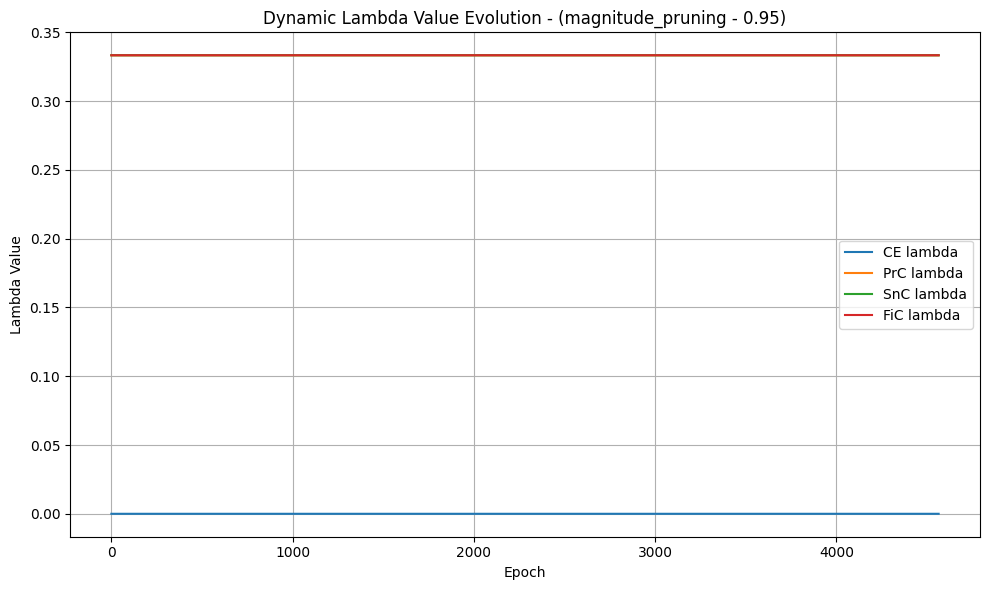

=== Lambda Statistics ===
CE lambda:
  Initial: 0.0000
  Final:   0.0000
  Change:  0.0000 (+inf%)
  Mean:    0.0000
  StdDev:  0.0000

PrC lambda:
  Initial: 0.3333
  Final:   0.3333
  Change:  0.0000 (+0.00%)
  Mean:    0.3333
  StdDev:  0.0000

SnC lambda:
  Initial: 0.3333
  Final:   0.3333
  Change:  0.0000 (+0.00%)
  Mean:    0.3333
  StdDev:  0.0000

FiC lambda:
  Initial: 0.3333
  Final:   0.3333
  Change:  0.0000 (+0.00%)
  Mean:    0.3333
  StdDev:  0.0000

[BaCP TRAINER] Mask generated from current model.
[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_ablation_b2.pt
[ERROR] Could not load weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_ablation_b2.pt
[ERROR] Attempting partial load
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (adamw, 0.0001)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAIN

Training epoch [1/50]: Avg Loss: 1.6870 | Avg Accuracy: 86.47 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [2/50]: Avg Loss: 0.6221 | Avg Accuracy: 90.89 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [3/50]: Avg Loss: 0.3126 | Avg Accuracy: 92.06 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [4/50]: Avg Loss: 0.2414 | Avg Accuracy: 92.75 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [5/50]: Avg Loss: 0.2048 | Avg Accuracy: 92.89 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [6/50]: Avg Loss: 0.1847 | Avg Accuracy: 93.50 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [7/50]: Avg Loss: 0.1692 | Avg Accuracy: 93.48 | Model Sparsity: 0.95



Training epoch [8/50]: Avg Loss: 0.1551 | Avg Accuracy: 94.27 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [9/50]: Avg Loss: 0.1444 | Avg Accuracy: 93.71 | Model Sparsity: 0.95



Training epoch [10/50]: Avg Loss: 0.1343 | Avg Accuracy: 93.92 | Model Sparsity: 0.95



Training epoch [11/50]: Avg Loss: 0.1245 | Avg Accuracy: 94.10 | Model Sparsity: 0.95



Training epoch [12/50]: Avg Loss: 0.1205 | Avg Accuracy: 94.25 | Model Sparsity: 0.95



Training epoch [13/50]: Avg Loss: 0.1106 | Avg Accuracy: 94.28 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [14/50]: Avg Loss: 0.1033 | Avg Accuracy: 94.53 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [15/50]: Avg Loss: 0.0995 | Avg Accuracy: 94.13 | Model Sparsity: 0.95



Training epoch [16/50]: Avg Loss: 0.0947 | Avg Accuracy: 93.82 | Model Sparsity: 0.95



Training epoch [17/50]: Avg Loss: 0.0890 | Avg Accuracy: 94.28 | Model Sparsity: 0.95



Training epoch [18/50]: Avg Loss: 0.0851 | Avg Accuracy: 94.29 | Model Sparsity: 0.95



Training epoch [19/50]: Avg Loss: 0.0795 | Avg Accuracy: 94.32 | Model Sparsity: 0.95



Training epoch [20/50]: Avg Loss: 0.0763 | Avg Accuracy: 94.46 | Model Sparsity: 0.95



Training epoch [21/50]: Avg Loss: 0.0721 | Avg Accuracy: 94.57 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [22/50]: Avg Loss: 0.0733 | Avg Accuracy: 94.59 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [23/50]: Avg Loss: 0.0656 | Avg Accuracy: 94.82 | Model Sparsity: 0.95

[TRAINER] weights saved!


Training epoch [24/50]: Avg Loss: 0.0640 | Avg Accuracy: 94.52 | Model Sparsity: 0.95



Training epoch [25/50]: Avg Loss: 0.0597 | Avg Accuracy: 94.27 | Model Sparsity: 0.95



Training epoch [26/50]: Avg Loss: 0.0562 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [27/50]: Avg Loss: 0.0538 | Avg Accuracy: 94.41 | Model Sparsity: 0.95



Training epoch [28/50]: Avg Loss: 0.0522 | Avg Accuracy: 94.50 | Model Sparsity: 0.95



Training epoch [29/50]: Avg Loss: 0.0510 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [30/50]: Avg Loss: 0.0464 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [31/50]: Avg Loss: 0.0449 | Avg Accuracy: 94.14 | Model Sparsity: 0.95



Training epoch [32/50]: Avg Loss: 0.0426 | Avg Accuracy: 94.56 | Model Sparsity: 0.95



Training epoch [33/50]: Avg Loss: 0.0417 | Avg Accuracy: 94.59 | Model Sparsity: 0.95



Training epoch [34/50]: Avg Loss: 0.0387 | Avg Accuracy: 94.61 | Model Sparsity: 0.95



Training epoch [35/50]: Avg Loss: 0.0373 | Avg Accuracy: 94.61 | Model Sparsity: 0.95



Training epoch [36/50]: Avg Loss: 0.0374 | Avg Accuracy: 94.60 | Model Sparsity: 0.95



Training epoch [37/50]: Avg Loss: 0.0367 | Avg Accuracy: 94.68 | Model Sparsity: 0.95



Training epoch [38/50]: Avg Loss: 0.0337 | Avg Accuracy: 94.39 | Model Sparsity: 0.95



Training epoch [39/50]: Avg Loss: 0.0319 | Avg Accuracy: 94.20 | Model Sparsity: 0.95



Training epoch [40/50]: Avg Loss: 0.0290 | Avg Accuracy: 94.82 | Model Sparsity: 0.95



Training epoch [41/50]: Avg Loss: 0.0286 | Avg Accuracy: 94.53 | Model Sparsity: 0.95



Training epoch [42/50]: Avg Loss: 0.0271 | Avg Accuracy: 94.73 | Model Sparsity: 0.95



Training epoch [43/50]: Avg Loss: 0.0294 | Avg Accuracy: 94.49 | Model Sparsity: 0.95

[TRAINER] Training stopped. No improvements for 20 epochs.
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_ablation_b2_finetune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     93.36%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        ablation_b2_finetune
  Batch Size:           512
  Learning Rate:        0.0001
  Optimizer:            adamw
  Epochs:               50

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24



In [ ]:
# Initializing finetuned weights path
finetuned_weights = f"./research/{MODEL_NAME}/{MODEL_TASK}/{MODEL_NAME}_{MODEL_TASK}_baseline.pt"



for i in range(4):
    lambdas = [1]*4
    lambdas[i] = 0
    types = ['no_ce', 'no_prc', 'no_snc', 'no_fic']
    trainer_instances = {}

    bacp_training_args = BaCPTrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.1),
    pruning_type='magnitude_pruning',
    target_sparsity=TARGET_SPARSITY_LOW,
    sparsity_scheduler='cubic',
    finetuned_weights=finetuned_weights,
    learning_type='ablation_b2_' + types[i],
    db=False,
    log_epochs=False,
    )

    bacp_trainer = BaCPTrainer(bacp_training_args, lambdas=lambdas)
    bacp_trainer.train()
    

    bacp_trainer.generate_mask_from_model()
    training_args = TrainingArguments(
        model_name=bacp_trainer.model_name,
        model_task=bacp_trainer.model_task,
        batch_size=bacp_trainer.batch_size,
        optimizer_type_and_lr=('adamw', 0.0001),
        pruner=bacp_trainer.get_pruner(),
        pruning_type=bacp_trainer.pruning_type,
        target_sparsity=bacp_trainer.target_sparsity,
        epochs=50,
        finetuned_weights=bacp_trainer.save_path,
        finetune=True,
        learning_type="ablation_b2_finetune",
        db=False,
    )
    trainer = Trainer(training_args)
    if True:
        trainer.train()

    metrics = trainer.evaluate()
    print_statistics(metrics, trainer)

In [13]:
training_args = TrainingArguments(
    model_name=MODEL_NAME,
    model_task=MODEL_TASK,
    batch_size=BATCH_SIZE_CNN,
    optimizer_type_and_lr=('sgd', 0.01),
    pruning_type='magnitude_pruning',
    target_sparsity=0.95,
    sparsity_scheduler='cubic',
    finetuned_weights=FINETUNED_WEIGHTS,
    learning_type="prune",
    db=False,

)
trainer = Trainer(training_args)
if False:
    trainer.train()

metrics = trainer.evaluate()
print_statistics(metrics, trainer)

[TRAINER] Image size: 32
[TRAINER] Initialized models
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_baseline.pt
[TRAINER] Weights loaded
[TRAINER] Optimizer type w/ learning rate: (sgd, 0.01)
[CV DATALOADERS] Loaded cifar10 with splits: ['train', 'validation', 'test']
[TRAINER] Data Initialized for model task: cifar10
[TRAINER] Batch size: 512
[TRAINER] Number of dataloders: 3
[TRAINER] No scheduler initialized
[TRAINER] Pruning initialized
[TRAINER] Pruning type: magnitude_pruning
[TRAINER] Target sparsity: 0.95
[TRAINER] Sparsity scheduler: cubic
[TRAINER] Pruning epochs: 5
[TRAINER] Current sparsity: 0.0000
[TRAINER] Saving model to: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_prune.pt
[TRAINER] Loading weights: ./research/resnet50/cifar10/resnet50_cifar10_magnitude_pruning_0.95_prune.pt
[TRAINER] Weights loaded successfully
[TRAINER] Model Sparsity: 0.95



TRAINING STATISTICS SUMMARY

Performance Metrics:
------------------------------
  Accuracy:     91.96%

Model Information:
------------------------------
  Total Parameters:     23,520,842
  Trainable Parameters: 23,520,842
  Model Sparsity:       0.9500 (95.00%)

Training Configuration:
------------------------------
  Model:                resnet50
  Task:                 cifar10
  Learning Type:        prune
  Batch Size:           512
  Learning Rate:        0.01
  Optimizer:            sgd
  Epochs:               5

Pruning Configuration:
------------------------------
  Pruning Type:         magnitude_pruning
  Target Sparsity:      0.95
  Sparsity Scheduler:   cubic
  Recovery Epochs:      10

System Information:
------------------------------
  Device:               cuda
  Mixed Precision:      True
  Workers:              24

